In [ ]:
# !pip install keras-tuner

In [ ]:
# Data from https://www.kaggle.com/datasets/davidhilton/apple-varieties-image-dataset/data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

import warnings
# filter warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Preprocessing:

* Reshape to 100 x 100 pixels
* Convert to LAB (Lightness, a-dimension (red-green color divergence), b-dimension (blue-yellow color divergence))
* append to array of images

In [ ]:
classes = ["LADY", "GRANNY SMITH", "RED DELICIOUS", "GOLDEN DELICIOUS", "FUJI"]
dir = '/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET'

np.random.seed(1234)

all_arrays = []
img_size = 100

for i in classes:
    path = os.path.join(dir, i) + "/"
    print(path)
    class_num = classes.index(i)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2LAB)
        img_array = cv2.resize(img_array,(100,100))
        all_arrays.append([img_array, class_num])

/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET/LADY/
/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET/GRANNY SMITH/
/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET/RED DELICIOUS/
/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET/GOLDEN DELICIOUS/
/content/drive/My Drive/apple_data/data/APPLE VARIETIES IMAGE DATASET/FUJI/


At the beginning we had images. We used os and cv2 libraries to created our array.

**Image examples of our data:**

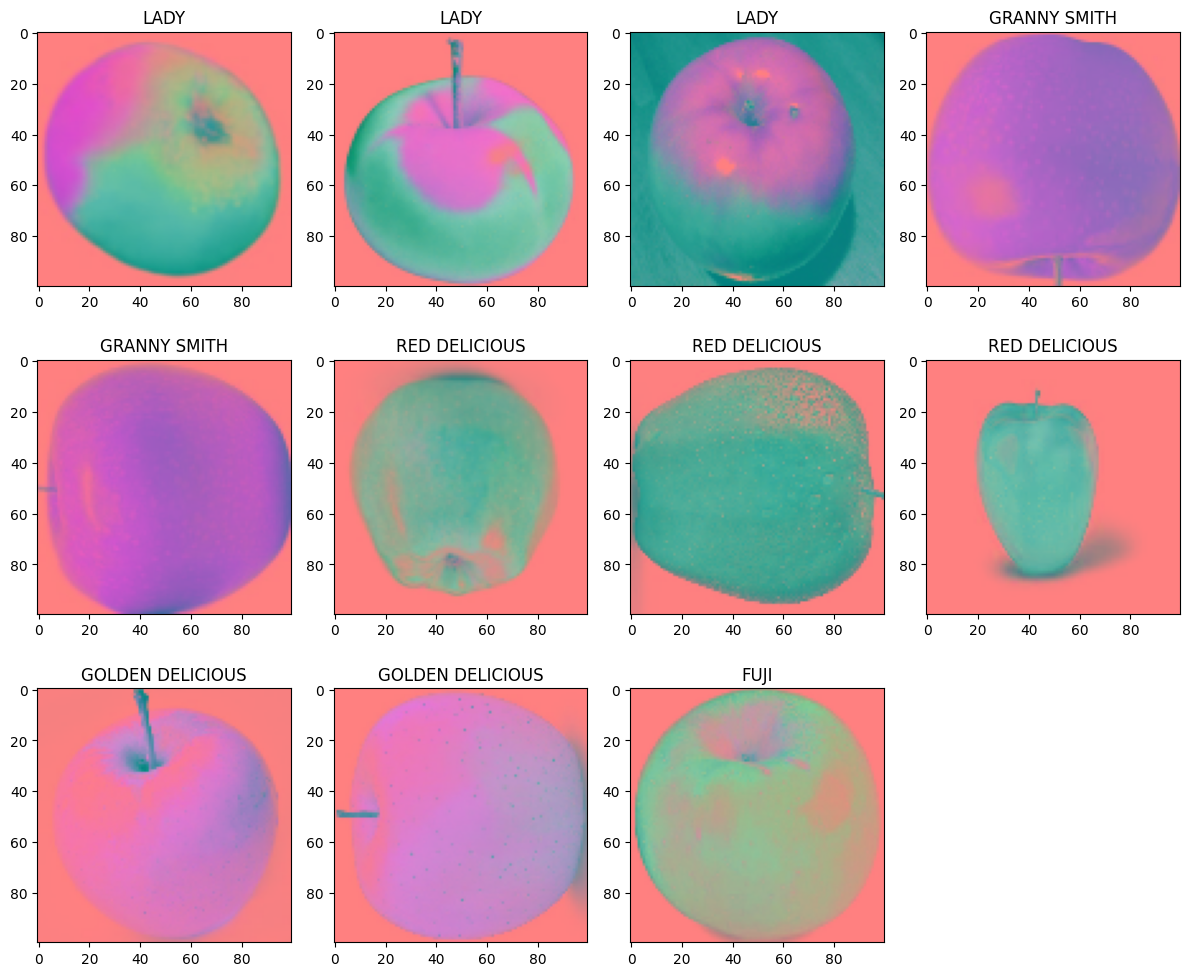

In [ ]:
fruits_array_train=[]
fruits_labels_train = []
for features,label in all_arrays:
    fruits_array_train.append(features)
    fruits_labels_train.append(label)
locations = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each image at the specified locations
for i, location in enumerate(locations):
    element = fruits_array_train[location]
    label = fruits_labels_train[location]

    # Determine the subplot location
    ax = axes[i]

    # Plot the image
    ax.imshow(element)
    ax.set_title(fruit_names[label])

# Hide any empty subplots
for i in range(len(locations), len(axes)):
    axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import random
random.shuffle(all_arrays)

X_train=[]
Y_train=[]
for features,label in all_arrays:
    X_train.append(features)
    Y_train.append(label)
X_train=np.array(X_train) #arraying

type(X_train)

numpy.ndarray

Create X features and Y labels, & use shuffle function to mix our dataset.

In [ ]:
# normalization and reshaping
img_size=100
print(X_train.shape)
X_train2=X_train.reshape(-1, img_size,img_size,3)
X_train2=X_train2/255

print("shape of X_train= ",X_train.shape)

(622, 100, 100, 3)
shape of X_train=  (622, 100, 100, 3)


While reshaping we added RGB scale.

In [ ]:
from keras.utils import to_categorical
Y_train2=to_categorical(Y_train,num_classes=5)

We converted our labels to one-hot-encoding values. 3 ----->(0,0,0,1,0) etc.

In [ ]:
print(Y_train2.shape)
print(X_train2.shape)

(622, 5)
(622, 100, 100, 3)


In [ ]:
# split to train & validation/testing
from sklearn.model_selection import  train_test_split
x_train, x_valtest, y_train, y_valtest=train_test_split(X_train2,Y_train2,test_size=0.3,random_state=42)

In [ ]:
# # split validation/testing into validation, testing
# x_val, x_test, y_val, y_test = train_test_split(x_valtest,y_valtest,test_size=0.5,random_state=42)

In [ ]:
print(x_train.shape)
print(x_valtest.shape)
# print(x_val.shape)

(435, 100, 100, 3)
(187, 100, 100, 3)


With train_test_split we separated our datas to train and validation datas.

# Create model

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Initialize the Sequential model
model = tf.keras.models.Sequential()

# Add the first convolutional layer
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding="Same", activation="relu", input_shape=(100, 100, 3)))

# Add the first max pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))

# Add dropout to prevent overfitting
model.add(Dropout(0.30))

# Add the second convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu"))

# Add the second max pooling layer
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Add dropout to prevent overfitting
model.add(Dropout(0.30)) #.3

# Flatten the data for fully connected layers
model.add(Flatten())

# Add the first fully connected layer
model.add(Dense(512, activation="relu")) #512

# Add dropout to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with softmax activation for multi-class classification
model.add(Dense(5, activation="softmax"))

# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define number of epochs and batch size for training
epochs = 10
batch_size = 24

# Train the model
jistory = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valtest, y_valtest))

Epoch 1/10
19/19 [==============================] - 13s 567ms/step - loss: 2.1587 - accuracy: 0.3126 - val_loss: 1.3531 - val_accuracy: 0.5989
Epoch 2/10
19/19 [==============================] - 8s 442ms/step - loss: 0.9945 - accuracy: 0.5885 - val_loss: 0.8446 - val_accuracy: 0.6310
Epoch 3/10
19/19 [==============================] - 10s 510ms/step - loss: 0.7381 - accuracy: 0.7241 - val_loss: 0.6692 - val_accuracy: 0.7487
Epoch 4/10
19/19 [==============================] - 10s 517ms/step - loss: 0.6564 - accuracy: 0.7218 - val_loss: 0.7856 - val_accuracy: 0.6898
Epoch 5/10
19/19 [==============================] - 8s 409ms/step - loss: 0.6564 - accuracy: 0.7379 - val_loss: 0.6074 - val_accuracy: 0.8449
Epoch 6/10
19/19 [==============================] - 10s 518ms/step - loss: 0.5053 - accuracy: 0.8069 - val_loss: 0.4744 - val_accuracy: 0.8984
Epoch 7/10
19/19 [==============================] - 10s 541ms/step - loss: 0.5269 - accuracy: 0.7862 - val_loss: 0.5449 - val_accuracy: 0.8503
E

In [ ]:
# This is an early stopping option to train the model

# from sklearn.metrics import confusion_matrix
# import itertools
# import tensorflow as tf

# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
# from keras.optimizers import Adam
# # from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ReduceLROnPlateau

# model= tf.keras.models.Sequential()

# model.add(Conv2D(filters=16,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(img_size,img_size,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.30))

# model.add(Conv2D(filters=32,kernel_size=(3,3),padding="Same",activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.30))

# model.add(Flatten())
# model.add(Dense(512,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(5,activation="softmax"))

# # add early stopping
# OPTIMIZER=Adam(learning_rate=3e-4)
# ES_callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=50, restore_best_weights=True
#     )
# ]
# from keras.callbacks import ModelCheckpoint
# # filepath='/content/drive/My Drive/apple_data/apples_model/model_4.3_color_lab_early_stopping.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# model.compile(optimizer=OPTIMIZER ,loss='categorical_crossentropy', metrics=['accuracy'])
# epochs=10
# batch_size=24
# jistory = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
19/19 [==============================] - 13s 461ms/step - loss: 2.6837 - accuracy: 0.2230 - val_loss: 1.5736 - val_accuracy: 0.3636
Epoch 2/10
19/19 [==============================] - 9s 459ms/step - loss: 1.5673 - accuracy: 0.2897 - val_loss: 1.5054 - val_accuracy: 0.4332
Epoch 3/10
19/19 [==============================] - 8s 414ms/step - loss: 1.2404 - accuracy: 0.5379 - val_loss: 1.2971 - val_accuracy: 0.6043
Epoch 4/10
19/19 [==============================] - 8s 409ms/step - loss: 0.9766 - accuracy: 0.6092 - val_loss: 1.0528 - val_accuracy: 0.7807
Epoch 5/10
19/19 [==============================] - 9s 456ms/step - loss: 0.7923 - accuracy: 0.6851 - val_loss: 0.8981 - val_accuracy: 0.7166
Epoch 6/10
19/19 [==============================] - 7s 354ms/step - loss: 0.6475 - accuracy: 0.7701 - val_loss: 0.7937 - val_accuracy: 0.7754
Epoch 7/10
19/19 [==============================] - 8s 448ms/step - loss: 0.6051 - accuracy: 0.7632 - val_loss: 0.7512 - val_accuracy: 0.7166
Epoch

Let's try data augmentation. In this section we add different shapes of our images. We will use **zooming,shifting,rotating,fliping** methods in order to avoid **overfitting**.

In [ ]:
# may play around with image manipulation

# from keras.preprocessing.image import ImageDataGenerator

# datagen=ImageDataGenerator(featurewise_center=False, #set input mean to 0
#                            samplewise_center=False,  #set each sample mean to 0
#                            featurewise_std_normalization=False, #divide input datas to std
#                            samplewise_std_normalization=False,  #divide each datas to own std
#                            zca_whitening=False,  #dimension reduction
#                            rotation_range=0.5,    #rotate 5 degree
#                            zoom_range=0.5,        #zoom in-out 5%
#                            width_shift_range=0.5, #shift 5%
#                            height_shift_range=0.5,
#                            horizontal_flip=False,  #randomly flip images
#                            vertical_flip=False,
#                            )
# datagen.fit(x_train)
# #model fitting
# history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,
#                             validation_data=(x_val,y_val),steps_per_epoch=x_train.shape[0]//batch_size
#                            )

Epoch 1/10
16/16 [==============================] - 10s 563ms/step - loss: 1.4242 - accuracy: 0.4521 - val_loss: 0.9449 - val_accuracy: 0.6700
Epoch 2/10
16/16 [==============================] - 7s 412ms/step - loss: 1.1737 - accuracy: 0.5372 - val_loss: 0.7858 - val_accuracy: 0.8000
Epoch 3/10
16/16 [==============================] - 9s 531ms/step - loss: 1.2034 - accuracy: 0.4495 - val_loss: 0.8802 - val_accuracy: 0.6900
Epoch 4/10
16/16 [==============================] - 7s 433ms/step - loss: 1.0750 - accuracy: 0.5559 - val_loss: 0.9159 - val_accuracy: 0.6600
Epoch 5/10
16/16 [==============================] - 9s 549ms/step - loss: 1.0630 - accuracy: 0.5239 - val_loss: 0.8682 - val_accuracy: 0.6700
Epoch 6/10
16/16 [==============================] - 6s 396ms/step - loss: 1.0572 - accuracy: 0.5479 - val_loss: 0.8606 - val_accuracy: 0.7300
Epoch 7/10
16/16 [==============================] - 8s 506ms/step - loss: 1.0352 - accuracy: 0.5745 - val_loss: 0.8076 - val_accuracy: 0.7100
Epoch

We connected our labels-layers with keras library. With Dense we added hidden layers. We avoided overfitting thanks to Dropout. With relu function we don't have variance around zero.

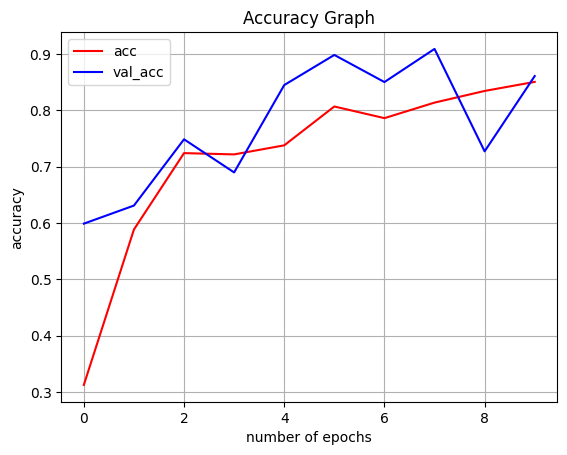

In [ ]:
plt.plot(jistory.history["accuracy"],color="r",label="acc")
plt.plot(jistory.history['val_accuracy'], color="b", label="val_acc")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

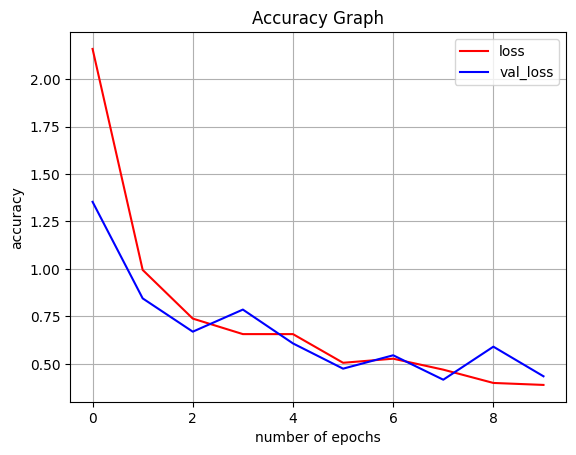

In [ ]:
plt.plot(jistory.history["loss"],color="r",label="loss")
plt.plot(jistory.history['val_loss'], color="b", label="val_loss")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

14/14 [==============================] - 4s 298ms/step


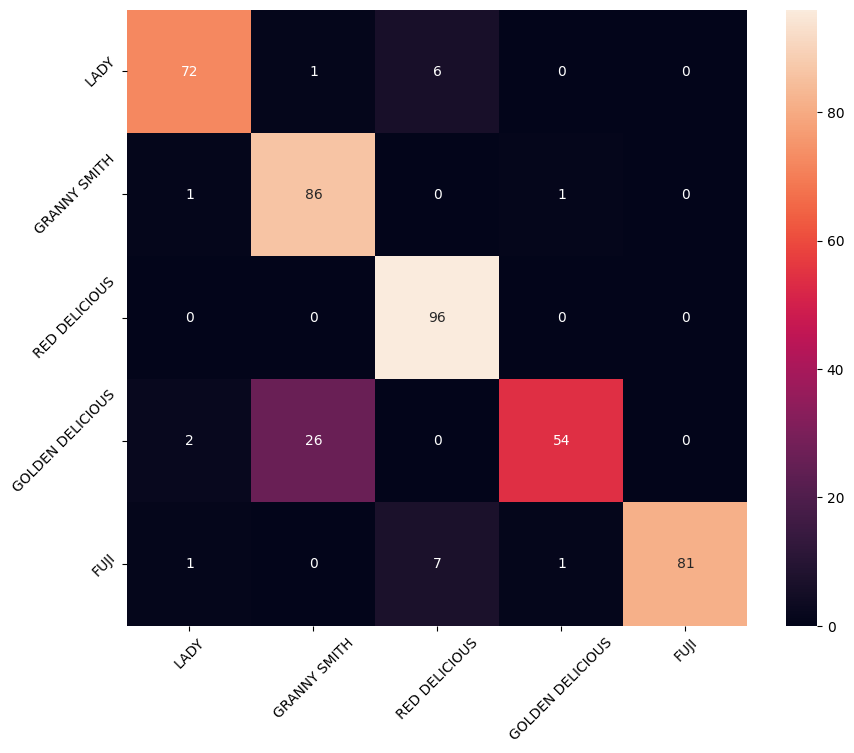

In [ ]:
#confusion matrix for training
y_pred=model.predict(x_train)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_train,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
fruit_names=["LADY", "GRANNY SMITH", "RED DELICIOUS", "GOLDEN DELICIOUS", "FUJI"]
f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(fruit_names, rotation = 45)
ax.set_yticklabels(fruit_names, rotation = 45)
plt.show()

6/6 [==============================] - 1s 108ms/step


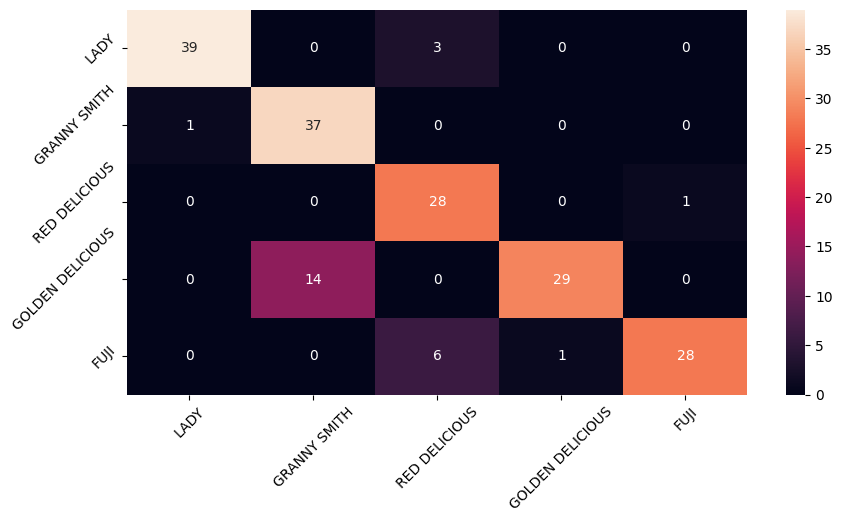

In [ ]:
#confusion matrix for validation
# misclassifying red delicious as fuji and granny smith as golden delicious

y_pred=model.predict(x_valtest)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_valtest,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
fruit_names=["LADY", "GRANNY SMITH", "RED DELICIOUS", "GOLDEN DELICIOUS", "FUJI"]
f,ax=plt.subplots(figsize=(10,5))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(fruit_names, rotation = 45)
ax.set_yticklabels(fruit_names, rotation = 45)
plt.show()


We can see error values on validation data

In [ ]:
loss, accuracy = model.evaluate(x_valtest, y_valtest)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

6/6 [==============================] - 1s 106ms/step - loss: 0.4343 - accuracy: 0.8610
Accuracy: 0.8609625697135925
Loss: 0.4342614710330963


In [ ]:
# Save/load a model
import tensorflow as tf
# model.save('/content/drive/My Drive/apple_data/final_models/.h5')
# model = tf.keras.models.load_model('/content/drive/My Drive/apple_data/final_models/best_apple_varieties.h5')


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 16)      1216      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 50, 50, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 50, 50, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 25, 25, 32)       

# Test model on unseen data that we found on Google (different dataset than original)
## 72% accurate, even on groups of apples and apples with different backgrounds

In [ ]:
# Get predictions on user-provided test images
# this does not remove background; seems to do more harm than good

import cv2 as cv
from PIL import Image
fruit_names=["LADY", "GRANNY SMITH", "RED DELICIOUS", "GOLDEN DELICIOUS", "FUJI"]

IMG_SIZE = 100
dir = "/content/drive/My Drive/apple_data/data/apple_varieties_testing/"
file_names = os.listdir(dir)
for img in file_names:
  img_test = cv2.imread(os.path.join(dir, img))
  img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2LAB)
  img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))  # Resize the image to (100, 100)
  img_test = img_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  prediction = model.predict(img_test)
  predicted_class_index = np.argmax(prediction)
  print(img, fruit_names[predicted_class_index], prediction)


1/1 [==============================] - 0s 131ms/step
granny_smith_1.jpg LADY [[1.0000000e+00 0.0000000e+00 1.6170283e-09 0.0000000e+00 0.0000000e+00]]
1/1 [==============================] - 0s 61ms/step
red_delicious_1.jpg RED DELICIOUS [[0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 48ms/step
red delicious.jpg RED DELICIOUS [[0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 53ms/step
Granny smith.jpg GRANNY SMITH [[0.0000000e+00 1.0000000e+00 0.0000000e+00 2.8416388e-21 0.0000000e+00]]
1/1 [==============================] - 0s 58ms/step
golden_group.jpg GOLDEN DELICIOUS [[0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 52ms/step
red_delicious_2.jpg RED DELICIOUS [[0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 64ms/step
red_delicious_3.jpg RED DELICIOUS [[0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 33ms/step
golden_delicious_2.jpg GOLDEN DELICIOUS [[0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 37ms/step
lady gr